# Paper approach
This notebook implements the method described in the research paper. The approach involves two main stages:

Feature Engineering:

Filtering features:
Selecting the most informative events based on a relevance metric.
Extracting sets of features: Mining recurring sets of events using an estimator of the Longest Common Subsequence (LCSS) algorithm.

Classification:
Building a classifier based on Naive Bayes, (the time-windows and classifiers for each time-window were not implemented since it was advised to put more effort in our own model implementations).

In [99]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

Loading data:

In [4]:
df = pd.read_csv('sncb_data_challenge.csv', delimiter=';')
df.head(2)

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
0,4432881,"[609, 609, 609, 609, 609, 609, 609, 609, 609, ...","[2744, 4004, 2852, 4110, 2854, 4396, 1132, 414...","[-5510, -5510, -5507, -5507, -5506, -5506, -55...",50.876601,4.718143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",4
1,4432943,"[526, 526, 526, 526, 526, 526, 526, 526, 526, ...","[2744, 4148, 4394, 1566, 1570, 4396, 3634, 412...","[-8573, -8573, -8032, -8032, -8032, -7859, -61...",51.037435,4.431218,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.1,...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13


Converting `events_sequence` and `vehicles_sequence` from string to list of ints:

In [6]:
df['events_sequence'] = df['events_sequence'].apply(ast.literal_eval)
df['vehicles_sequence'] = df['vehicles_sequence'].apply(ast.literal_eval)

Next calculate total frequency of events in total and frequency of events within each class:

In [8]:
# Total occurrences of each event across all classes
total_event_counts = Counter()
# Occurrences of each event within each class
event_counts_per_class = {}

for incident_type in df['incident_type'].unique():
    event_counts_per_class[incident_type] = Counter()

for idx, row in df.iterrows():
    events = set(row['events_sequence'])  # Use set to avoid duplicate events in the same sequence
    incident_type = row['incident_type']
    total_event_counts.update(events)
    event_counts_per_class[incident_type].update(events)

r is described in the paper as: $$ r = \frac{h_{\text{in class}}}{h_{\text{in all classes}}} $$ 
where ℎ is an event frequency in class or in all classes. This metric is calculated:


In [10]:
relevance_metric = {}

for event in total_event_counts:
    #The maximum h_in class is used
    max_h_in_class = max([event_counts_per_class[cls][event] for cls in event_counts_per_class])
    h_in_all_classes = total_event_counts[event]
    relevance_metric[event] = max_h_in_class / h_in_all_classes

Next we can define a threshold and keep the events equal and over the threshold:

In [12]:
# Set initial threshold
tr = 0.5

selected_events = [event for event, r in relevance_metric.items() if r >= tr]

print(f"Number of events selected with r >= {tr}: {len(selected_events)}")

Number of events selected with r >= 0.5: 635


Next we separate the events in those that were not included

In [14]:
# Events not selected
remaining_events = [event for event in total_event_counts if event not in selected_events]

# Placeholder for events that pass the OaT procedure
additional_events = []

A function is made to calculate the f1 score for a specific subset of the total events

In [16]:
def evaluate_classifier(events_subset):
    # Prepare the data
    df['filtered_events'] = df['events_sequence'].apply(lambda x: [e for e in x if e in events_subset])
    
    # Convert event lists to strings for vectorization
    df['events_str'] = df['filtered_events'].apply(lambda x: ' '.join(map(str, x)))
    
    # Vectorize the events
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['events_str'])
    y = df['incident_type']
    
    # Perform stratified 4-fold cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = MultinomialNB()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        f1_scores.append(f1)
    
    avg_f1_score = np.mean(f1_scores)
    return avg_f1_score

Iterating over all events that were filtered out, find the ones that when included , lead to an average f1 score of 0.6 or greater and include them in the `current_events` which are used to make the classification

In [18]:
# Current set of events
current_events = selected_events.copy()

# Evaluate classifier with current events
current_f1_score = evaluate_classifier(current_events)
print(f"Initial F1-score with selected events: {current_f1_score:.4f}")

# Iterate over remaining events
for event in tqdm(remaining_events, desc='OaT Procedure'):
    temp_events = current_events + [event]
    f1 = evaluate_classifier(temp_events)
    if f1 >= 0.6:
        current_events.append(event)
        additional_events.append(event)
        current_f1_score = f1  # Update the current F1-score

print(f"Final F1-score after OaT: {current_f1_score:.4f}")
print(f"Number of additional events added: {len(additional_events)}")

Initial F1-score with selected events: 0.6309


OaT Procedure: 100%|█████████████████████████████████████████████████████████████████| 282/282 [20:53<00:00,  4.45s/it]

Final F1-score after OaT: 0.6006
Number of additional events added: 241


Count total event frequencies and filter out extremely rare events:

In [20]:
# Count event frequencies
event_counts = Counter([event for seq in df['events_sequence'] for event in seq])

# Define a minimum frequency threshold
min_event_frequency = 10  # Adjust based on dataset

# Filter out rare events
frequent_events = set([event for event, count in event_counts.items() if count >= min_event_frequency])

# Update events_sequence by keeping only frequent events
df['filtered_events_sequence'] = df['events_sequence'].apply(lambda seq: [event for event in seq if event in frequent_events])

Prepare the data for frequent itemset mining:

In [22]:
transactions = df['filtered_events_sequence'].tolist()

# Remove empty transactions
transactions = [t for t in transactions if t]

# Use TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

Next we calculate the most frequent sequences using fpgrothw algorithm. However, due to huge cost and processing times, `max_length` is set to 2.
Of course, the results will not be optimal, however, it is possible to run the notebook in our laptops

In [24]:
# Apply the FP-Growth algorithm to find frequent itemsets
min_support = 0.05  # Adjust as needed based on dataset size

frequent_itemsets = fpgrowth(df_te, min_support=min_support, use_colnames=True, max_len=2)

print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
frequent_itemsets.head(5)

Number of frequent itemsets found: 5380


,support,itemsets
0,0.993076,(2708)
1,0.985163,(4026)
2,0.941642,(4066)
3,0.934718,(4068)
4,0.907023,(4148)


Next, we create the columns corresponding to each frequent sequence, checking if in a particular row the frequent sequence appers at least once:

In [26]:
# Convert frequent itemsets into a list of tuples
frequent_sets = [tuple(tup) for tup in frequent_itemsets['itemsets']]

# Function that checks if the exact sequence of events from the tuple is found in the list
def is_tuple_in_list(seq, lst):
    # Convert the tuple to a list to make it easier to check for a subsequence
    seq_list = list(seq)
    # Iterate through the list and check if the subsequence appears
    for i in range(len(lst) - len(seq_list) + 1):
        if lst[i:i+len(seq_list)] == seq_list:
            return 1
    return 0

# Create new features for each frequent itemset in one batch
new_columns = {
    f'itemset_{idx}': df['events_sequence'].apply(lambda x: int(is_tuple_in_list(itemset, x)))
    for idx, itemset in enumerate(frequent_sets)
}

# Add all new features to the DataFrame at once
df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

df.head(5)

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type,...,itemset_5370,itemset_5371,itemset_5372,itemset_5373,itemset_5374,itemset_5375,itemset_5376,itemset_5377,itemset_5378,itemset_5379
0,4432881,"[609, 609, 609, 609, 609, 609, 609, 609, 609, ...","[2744, 4004, 2852, 4110, 2854, 4396, 1132, 414...","[-5510, -5510, -5507, -5507, -5506, -5506, -55...",50.876601,4.718143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",4,...,0,0,0,0,0,0,0,0,0,0
1,4432943,"[526, 526, 526, 526, 526, 526, 526, 526, 526, ...","[2744, 4148, 4394, 1566, 1570, 4396, 3634, 412...","[-8573, -8573, -8032, -8032, -8032, -7859, -61...",51.037435,4.431218,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.1,...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13,...,0,0,0,0,0,0,0,0,0,0
2,4432955,"[592, 592, 592, 592, 592, 592, 592, 592, 592, ...","[4394, 1566, 1570, 4114, 4168, 4168, 4156, 406...","[-12291, -12291, -12291, -10932, -10932, -1091...",50.864083,4.162115,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, False, True, Tr...",14,...,0,0,0,0,0,0,0,0,0,0
3,4433021,"[576, 576, 576, 576, 576, 576, 576, 576, 576, ...","[4066, 4066, 4066, 4066, 4068, 2742, 4026, 270...","[-14351, -14204, -13890, -13383, -12739, -1243...",51.183220,4.276025,"[0.0, 0.0, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",2,...,0,0,0,0,0,0,0,0,0,0
4,4433129,"[634, 634, 634, 634, 634, 634, 634, 634, 634, ...","[4002, 4032, 4028, 2852, 4026, 4110, 2742, 285...","[-224, -224, -223, -222, -222, -222, -220, -22...",50.818727,3.253601,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,...,0,0,0,0,0,0,0,0,0,0


# Model evaluation
Now we can evaluate the model on the f1 metric:

In [28]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, LeaveOneOut
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

Custom scoring function that allows zero devision and concerns the weighted f1 score:

In [30]:
# Create a custom scoring function with zero_division parameter
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Wrap the custom scoring function using make_scorer
f1_scorer = make_scorer(custom_f1_score)

Splitting the data into the samples and the target

In [32]:
target = df.incident_type.copy()
class_counts = target.value_counts()
max_class_count = max(class_counts.values)
sampling_strategy_cross_val = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}
X_data = df.drop(columns=['incident_id', 'vehicles_sequence', 'events_sequence',
       'seconds_to_incident_sequence', 'approx_lat', 'approx_lon',
       'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence',
       'incident_type','filtered_events_sequence','filtered_events','events_str']).copy()
X_data.head(2)

,itemset_0,itemset_1,itemset_2,itemset_3,itemset_4,itemset_5,itemset_6,itemset_7,itemset_8,itemset_9,...,itemset_5370,itemset_5371,itemset_5372,itemset_5373,itemset_5374,itemset_5375,itemset_5376,itemset_5377,itemset_5378,itemset_5379
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Now we can use gridsearchCV to find the optimal parameters for the MultinomialNB():

In [46]:
model = MultinomialNB()

param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5],
    'fit_prior': [True, False]
}

# Cross-validation strategy set here to replicate results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Define GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=f1_scorer, n_jobs=6)

# Fit GridSearchCV to the data
grid_search.fit(X_data, target)
best_params = grid_search.best_params_

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score F1:", grid_search.best_score_)

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\stef4\anaconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\stef4\anaconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\stef4\anaconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\stef4\anaconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return 

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Score F1: 0.5399506186526576


In [80]:
print("St Dev f1:", str(np.std(cross_val_score(grid_search.best_estimator_, X_data, target, cv=cv, scoring=f1_scorer))))

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


St Dev f1: 0.01117859157694585


Also accuracy:

In [72]:
print("Accuracy:", str(np.mean(cross_val_score(grid_search.best_estimator_, X_data, target, cv=cv, scoring='accuracy'))))
print("St Dev accuracy:", str(np.std(cross_val_score(grid_search.best_estimator_, X_data, target, cv=cv, scoring='accuracy'))))

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.5568892357216018


C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


St Dev accuracy: 0.012957183706862087


Next use the parameters found in gridsearch and also split the data in training and testing and create the classification report:

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2,  random_state=3, stratify=target)
# Train a new model with the best parameters
best_model = MultinomialNB(**best_params)
best_model.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Also the classification report:

In [336]:
y_pred = best_model.predict(X_test)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Weighted F1-score: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred, zero_division=1))

Weighted F1-score: 0.5749
              precision    recall  f1-score   support

           2       0.64      0.88      0.74        24
           3       1.00      0.00      0.00         1
           4       0.44      0.44      0.44        16
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         1
           9       0.38      0.52      0.44        23
          11       1.00      0.00      0.00         5
          13       0.86      0.66      0.74        64
          14       0.62      0.77      0.69        30
          16       1.00      0.00      0.00         1
          17       1.00      0.00      0.00         2
          99       0.39      0.40      0.39        35

    accuracy                           0.59       203
   macro avg       0.78      0.30      0.29       203
weighted avg       0.64      0.59      0.57       203



Next the confusion matrix:

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\stef4\AppData\Local\Temp\ipykernel_17212\2181126367.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


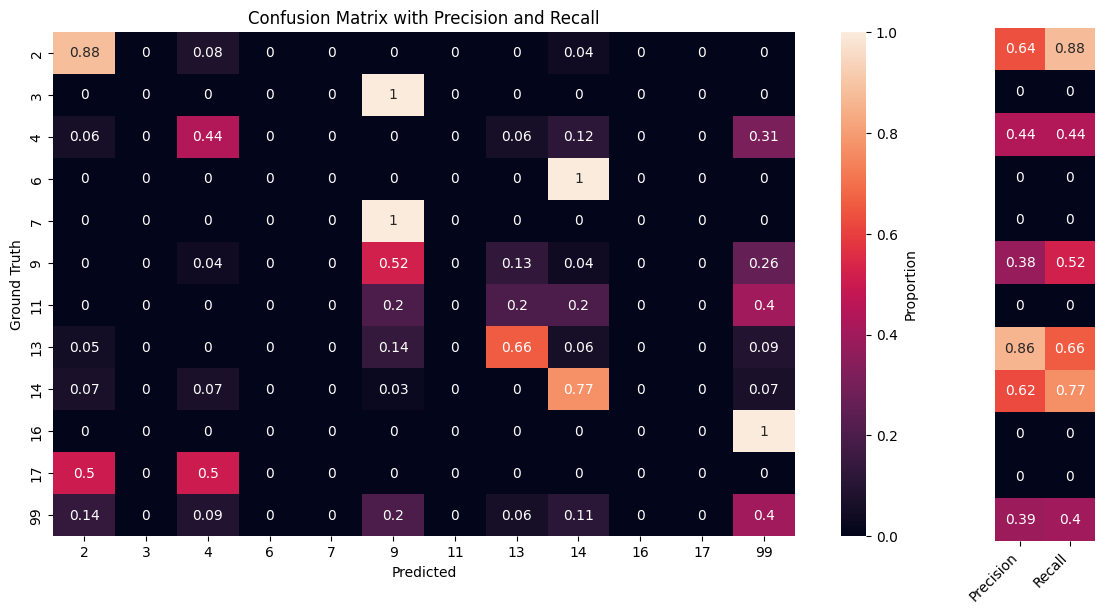

In [339]:
categories = np.unique(y_train) 

y_pred = y_pred
# Compute confusion matrix
conf_matrix = np.round(confusion_matrix(y_test, y_pred, normalize="true"),2)  # Normalized confusion matrix
precision = precision_score(y_test, y_pred, average=None)  # Per-class precision
recall = recall_score(y_test, y_pred, average=None)        # Per-class recall

# Plot the main confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap="rocket", 
    cbar_kws={'label': 'Proportion'}, 
    xticklabels=categories, 
    yticklabels=categories,
    ax=ax
)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix with Precision and Recall")

# Add precision and recall as a sidebar heatmap
prec_rec = np.array([precision, recall]).T  # Shape (n_classes, 2)
side_ax = ax.figure.add_axes([1, ax.get_position().y0 - 0.02, 0.1, ax.get_position().height + 0.085])  # Match size
sns.heatmap(
    prec_rec, 
    annot=True, 
    cmap="rocket", 
    cbar=False, 
    xticklabels=["Precision", "Recall"], 
    yticklabels=categories,
    vmin=0, 
    vmax=1,
    ax=side_ax
)
side_ax.set_xticklabels(side_ax.get_xticklabels(), rotation=45, ha="right")
side_ax.set_yticks([])  # Remove y-ticks to match visual style

plt.tight_layout()
plt.show()

## Comparison with dummy model
Next we create dummy classifier to see if our model brings some value. With parameter `stratified`, the classifier generates predictions by randomly sampling the classes in a way that respects the class distribution. For example, if the training set contains 70% of samples labeled as `0` and 30% labeled as `1`, the classifier will predict 0 approximately 70% of the time and 1 approximately 30% of the time:

In [342]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

# Evaluate dummy classifier
dummy_y_pred = dummy_clf.predict(X_test)
f1_weighted = f1_score(y_test, dummy_y_pred, average='weighted', zero_division=0)
print(f"Weighted F1-score: {f1_weighted:.4f}")
print(classification_report(y_test, dummy_y_pred, zero_division=1))

Weighted F1-score: 0.1759
              precision    recall  f1-score   support

           2       0.22      0.21      0.21        24
           3       0.00      0.00      0.00         1
           4       0.07      0.12      0.09        16
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           9       0.06      0.04      0.05        23
          11       0.00      0.00      0.00         5
          13       0.32      0.30      0.31        64
          14       0.15      0.13      0.14        30
          16       0.00      0.00      0.00         1
          17       1.00      0.00      0.00         2
          99       0.11      0.11      0.11        35

    accuracy                           0.17       203
   macro avg       0.16      0.08      0.08       203
weighted avg       0.19      0.17      0.18       203



Also the cross validation scores:

In [345]:
print("F1:", str(np.mean(cross_val_score(dummy_clf, X_data, target, cv=cv, scoring=f1_scorer))))
print("St Dev f1:", str(np.std(cross_val_score(dummy_clf, X_data, target, cv=cv, scoring=f1_scorer))))
print("Accuracy:", str(np.mean(cross_val_score(dummy_clf, X_data, target, cv=cv, scoring='accuracy'))))
print("St Dev accuracy:", str(np.std(cross_val_score(dummy_clf, X_data, target, cv=cv, scoring='accuracy'))))

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


F1: 0.16327604157871778
St Dev f1: 0.03870961102017974


C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.18693361947032142
St Dev accuracy: 0.027874596498023367


Also, the confusion matrix

C:\Users\stef4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\stef4\AppData\Local\Temp\ipykernel_17212\593516017.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


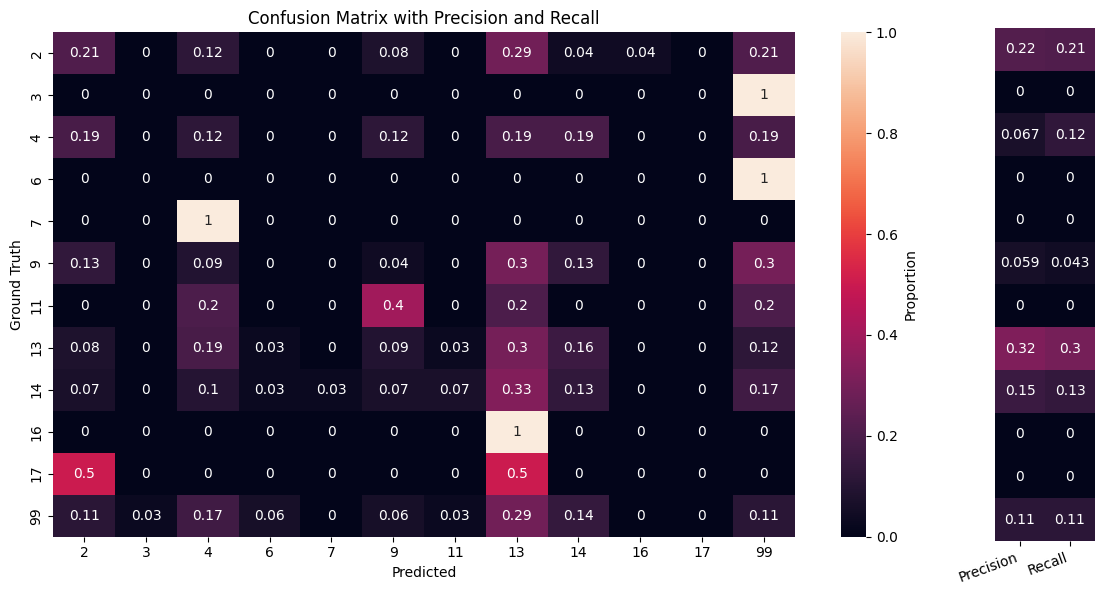

In [350]:
categories = np.unique(y_train) 

y_pred = dummy_y_pred
# Compute confusion matrix
conf_matrix = np.round(confusion_matrix(y_test, y_pred, normalize="true"),2)  # Normalized confusion matrix
precision = precision_score(y_test, y_pred, average=None)  # Per-class precision
recall = recall_score(y_test, y_pred, average=None)        # Per-class recall

# Plot the main confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap="rocket", 
    cbar_kws={'label': 'Proportion'}, 
    xticklabels=categories, 
    yticklabels=categories,
    ax=ax
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix with Precision and Recall")

# Add precision and recall as a sidebar heatmap
prec_rec = np.array([precision, recall]).T  # Shape (n_classes, 2)
side_ax = ax.figure.add_axes([1, ax.get_position().y0 - 0.02, 0.1, ax.get_position().height + 0.085])  # Match size
sns.heatmap(
    prec_rec, 
    annot=True, 
    cmap="rocket", 
    cbar=False, 
    xticklabels=["Precision", "Recall"], 
    yticklabels=categories,
    vmin=0, 
    vmax=1,
    ax=side_ax
)
side_ax.set_xticklabels(side_ax.get_xticklabels(), rotation=20, ha="right")
side_ax.set_yticks([])  # Remove y-ticks to match visual style

plt.tight_layout()
plt.show()